In [1]:
import pandas as pd
import re
import numpy as np
import av
import torch
import pickle
from transformers import AutoImageProcessor, VideoMAEModel
from huggingface_hub import hf_hub_download
from huggingface_hub import hf_hub_download
import os
import pandas as pd
import glob

/home/orchid/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-08 18:22:42.883078: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 18:22:43.494014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(0)
def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices



# Function to extract video features
def extract_video_features(file_path, device):
    # Open the video file
    container = av.open(file_path)
    
    # Sample 16 frames
    indices = sample_frame_indices(clip_len=16, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
    video = read_video_pyav(container, indices)

    # Load image processor and model
    image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
    model = VideoMAEModel.from_pretrained("MCG-NJU/videomae-base")
    model.to(device)

    # Process the video frames
    inputs = image_processor(list(video), return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state

    # Extract features (mean pooling) and move to CPU
    #features = last_hidden_states.mean(dim=1).squeeze().to("cpu").numpy()
    features = last_hidden_states.to("cpu").numpy()
    
    return features



file_path = "/home/orchid/Documents/HumourDetection/Sarthak_Sharma/test.mp4"
video_features = extract_video_features(file_path, device)
print("Video features are: ", video_features)
print("Video features shape is: ",video_features.shape)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Video features are:  [[[-0.20150954  0.10641037  0.15078397 ...  0.16234218  0.21982941
   -0.01695007]
  [-0.18256672  0.25126567  0.08090174 ... -0.09435058  0.2113281
   -0.33852363]
  [-0.59851354 -0.02534099  0.14390539 ...  0.06186688  0.27428934
   -0.31065947]
  ...
  [ 0.02293628 -0.08004195 -0.01137044 ... -0.4421075   0.1411792
   -0.13282551]
  [ 0.03572875 -0.6312445   0.10911979 ... -0.3974313   0.13793896
   -0.18948828]
  [ 0.19683483 -0.07137296  0.09209517 ... -0.10810854 -0.24036232
   -0.50849515]]]
Video features shape is:  (1, 1568, 768)


/home/orchid/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(value)


In [3]:
import torchaudio
import torchaudio.transforms
import torch
import numpy as np
from transformers import VideoMAEImageProcessor, VideoMAEModel, ASTFeatureExtractor, ASTModel

# Define the audio processor and model (please adjust these to your actual audio processor and model)
audio_processor = ASTFeatureExtractor()
audio_model = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593").to(device)

audio_folder = "/home/orchid/Documents/HumourDetection/data/audio/"
filename = "3.wav"


def audio_features(folder, file):
    audio_segment_path = os.path.join(audio_folder, filename)
    
    # Load stereo audio
    stereo_audio, sample_rate = torchaudio.load(audio_segment_path)
    
    # Convert stereo to mono
    mono_audio = stereo_audio.mean(dim=0)
    
    # Resample to 16 kHz
    resample = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    mono_audio_16khz = resample(mono_audio)
    
    inputs = audio_processor(mono_audio_16khz, sampling_rate=16000, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = audio_model(**inputs)
    
    last_hidden_states = outputs.last_hidden_state 
    
    features_audio = last_hidden_states.cpu().numpy()

    return features_audio

wav_features = audio_features(audio_folder, filename)

print("Audio features are:", wav_features)
print("Audio shape is: ", wav_features.shape)

Audio features are: [[[ 1.191034   -0.86182666  0.7861506  ... -0.4835069  -1.9844493
   -1.1308769 ]
  [ 1.8293048  -0.02175863  0.3962268  ... -0.848516   -1.8734795
    0.01657532]
  [-0.05718609 -2.1964457  -1.8482432  ... -0.9581685  -1.1962581
    0.02739693]
  ...
  [ 1.5760692   0.22794232  0.5403923  ... -0.17241687 -0.93183804
    1.5035613 ]
  [ 1.2421161   0.81869113  0.45062426 ...  0.5453742  -1.0154021
    1.4612745 ]
  [ 1.1515828   0.5166324   0.36261547 ... -0.16463384 -1.1765784
    0.85446   ]]]
Audio shape is:  (1, 1214, 768)


In [4]:
import torchaudio
import torchaudio.transforms
import torch
import numpy as np
from transformers import VideoMAEImageProcessor, VideoMAEModel, ASTFeatureExtractor, ASTModel

torch.cuda.set_device(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the audio processor and model (please adjust these to your actual audio processor and model)
audio_processor = ASTFeatureExtractor()
audio_model = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593").to(device)

def wavaudio_features(file):
    #audio_segment_path = os.path.join(audio_folder, filename)
    
    # Load stereo audio
    stereo_audio, sample_rate = torchaudio.load(file)
    
    # Convert stereo to mono
    mono_audio = stereo_audio.mean(dim=0)
    
    # Resample to 16 kHz
    resample = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    mono_audio_16khz = resample(mono_audio)
    
    inputs = audio_processor(mono_audio_16khz, sampling_rate=16000, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = audio_model(**inputs)
    
    last_hidden_states = outputs.last_hidden_state 
    
    features_audio = last_hidden_states.cpu().numpy()

    return features_audio

In [9]:
import tensorflow as tf
from tensorflow.keras.models import load_model

saved_model_path = 'D:\ML Projects\model_final1'
# Load the model
loaded_model = tf.saved_model.load(saved_model_path)

# Print confirmation message
print("Model loaded successfully from:", saved_model_path)

Model loaded successfully from: D:\ML Projects\model_final1


MoviePy - Writing audio in D:\ML Projects\extracted_audio.wav


MoviePy - Done.
Audio Embedding:  [[[ 0.33431408  2.2124386  -0.8445755  ... -0.1611506   0.4968712
   -2.0509777 ]
  [ 1.0853901   2.1818087  -0.6193892  ...  0.07972098 -0.38214964
   -1.3964171 ]
  [-0.24444287 -0.8186928  -0.5712275  ... -0.97681177  0.66468704
    0.5714718 ]
  ...
  [ 1.304396    1.3394122   0.03403103 ...  0.06736712 -1.2457542
    1.2240554 ]
  [ 0.98376095  0.83737105  0.6235462  ... -0.21965894 -0.71496016
    0.7897501 ]
  [ 0.36060706 -0.7909695  -0.4514681  ... -1.0221639   0.5853548
    0.3397434 ]]]
Audio Embedding Shape: (1, 1214, 768)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Video Embedding:  [[[-0.66943043 -0.02284431  0.2206536  ...  0.54728967 -0.00198382
    0.00403971]
  [-0.5225351   0.03984598  0.2148189  ...  0.22420979  0.01187528
   -0.184603  ]
  [-0.01512496  0.17177533  0.13948405 ...  0.01360554 -0.22231364
   -0.13712738]
  ...
  [-0.48227045  0.09424184  0.06855292 ...  0.08318885 -0.07362238
   -0.13536066]
  [ 0.006126    0.00677874 -0.000942   ...  0.19703971 -0.21764843
   -0.15255035]
  [-0.01635026  0.01026905  0.10821235 ...  0.13031225 -0.2826406
   -0.40221152]]]
Video Embedding Shape:  (1, 1568, 768)
MoviePy - Writing audio in D:\ML Projects\extracted_audio.wav


MoviePy - Done.
Audio Embedding:  [[[ 0.43375537  1.1094348  -1.8315333  ...  0.8400884  -1.2965431
   -1.429176  ]
  [ 0.43521598  1.4103078  -1.7987262  ...  0.9318343  -1.924275
   -0.91314214]
  [-0.59659827  0.03657202 -0.8152971  ... -1.476133    0.64240545
    1.3830171 ]
  ...
  [ 1.8831717   0.77996874 -0.623962   ... -0.21777035 -0.5765724
    0.9970775 ]
  [ 1.2795733   1.9762459  -0.17476776 ... -0.1722551   0.2571807
    1.107749  ]
  [ 1.2426406   0.29543126  0.23084196 ...  0.16540356 -1.4532506
    0.52000946]]]
Audio Embedding Shape: (1, 1214, 768)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Video Embedding:  [[[-0.67496526 -0.16689168  0.00309786 ...  0.4044849   0.28381547
   -0.09440754]
  [-0.7499716   0.0297902   0.00213556 ...  0.1278393   0.05692562
   -0.195641  ]
  [-0.7535519   0.1092779   0.04281272 ...  0.0116147  -0.00442696
   -0.13022965]
  ...
  [ 0.19372335  0.05082093  0.06332798 ...  0.23009314  0.0419806
    0.027273  ]
  [ 0.15551293  0.13090776 -0.09445952 ...  0.20451201  0.0300258
    0.06376215]
  [ 0.13266358  0.32629788 -0.03765151 ... -0.0405491   0.03523505
   -0.18815447]]]
Video Embedding Shape:  (1, 1568, 768)
MoviePy - Writing audio in D:\ML Projects\extracted_audio.wav


MoviePy - Done.
Audio Embedding:  [[[ 0.7231356   0.4675637  -0.3189858  ...  0.7056228  -0.94219774
   -1.5716035 ]
  [ 1.1004004   0.77942383 -0.11911581 ...  0.4512744  -2.1276817
   -0.87229747]
  [ 0.4311535   1.6701133   1.9795607  ... -0.21100384 -0.13896194
    0.2295305 ]
  ...
  [-0.11609559 -1.0771892  -1.2179308  ... -1.1950248  -0.74611115
   -0.12764265]
  [-0.00771218 -1.0696166  -1.1358908  ... -0.8392036  -1.4581381
    1.3037322 ]
  [ 1.1005284  -0.09609251  1.7884499  ...  0.9000661  -2.5379517
    0.7195595 ]]]
Audio Embedding Shape: (1, 1214, 768)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Video Embedding:  [[[-0.12019121  0.0041648  -0.03491041 ...  0.40883902  0.35373008
    0.40590763]
  [-0.05360812  0.20165147  0.2502199  ...  0.06857957 -0.01904523
   -0.02741919]
  [ 0.20547393  0.49038887  0.16338937 ... -0.22597195 -0.08427478
    0.13647176]
  ...
  [-0.11632685 -0.10238498 -0.02628828 ...  0.12780415  0.12359007
    0.22722557]
  [ 0.68430316 -0.13412233  0.03607459 ...  0.0439015   0.21665794
    0.21818297]
  [ 0.72314614  0.26221535 -0.11582197 ...  0.0388022   0.02615647
   -0.25826308]]]
Video Embedding Shape:  (1, 1568, 768)
MoviePy - Writing audio in D:\ML Projects\extracted_audio.wav


MoviePy - Done.
Audio Embedding:  [[[-1.3324528   1.1655314  -0.28824782 ... -0.08973926  0.82476145
   -0.93810904]
  [-0.9297563   1.9250593  -0.11991393 ...  0.1388923   0.23841603
   -0.576528  ]
  [ 0.27829707 -0.15524784  1.0290937  ... -0.3313816  -0.10484274
    0.4364292 ]
  ...
  [ 1.3748814   1.4206499   0.35553455 ... -0.5000563  -1.6028473
    1.4006206 ]
  [ 0.35511887  0.37037137  1.2122477  ...  0.18942721 -0.7770635
    1.4567813 ]
  [ 1.0735779   0.5518291  -0.53185767 ... -0.65818584 -0.62269855
    0.99656826]]]
Audio Embedding Shape: (1, 1214, 768)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Video Embedding:  [[[-0.54314846 -0.09826795 -0.47290543 ...  0.05785008 -0.0998186
    0.2699861 ]
  [-0.3361115   0.27622333 -0.14190045 ... -0.07701316 -0.01466552
   -0.24541765]
  [ 0.05209306  0.00776547 -0.0980038  ...  0.05137968 -0.09490983
   -0.21581034]
  ...
  [-0.83793694 -0.3017175  -0.05859634 ...  0.24116737  0.18844622
    0.20471917]
  [ 0.26415756 -0.16087165 -0.00152611 ...  0.34738648  0.05282116
    0.23134792]
  [-0.01549175 -0.14875428  0.18104543 ...  0.10248588 -0.07668442
   -0.20095997]]]
Video Embedding Shape:  (1, 1568, 768)
MoviePy - Writing audio in D:\ML Projects\extracted_audio.wav


MoviePy - Done.


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Audio Embedding:  [[[-0.09042823  1.6296769  -1.5634011  ... -0.04187195  0.241395
   -0.6648562 ]
  [-0.3407188   2.2691796  -1.709471   ... -0.07789677 -0.36976093
   -0.19494718]
  [ 0.01042116  0.07627921  0.0836433  ... -0.5428678   0.01679088
    0.85653436]
  ...
  [ 0.9220491  -0.35188484 -1.7485733  ... -0.5296286   0.5067303
    0.3414288 ]
  [ 0.9140345   0.47358218  2.747752   ... -1.1986322   0.555704
    0.85304123]
  [ 1.3330257   0.18236159  2.050901   ...  0.08616997  0.28406295
    1.3713312 ]]]
Audio Embedding Shape: (1, 1214, 768)
Video Embedding:  [[[-0.62778896  0.02069545 -0.22098424 ...  0.3752849   0.24784487
    0.10977992]
  [-0.5828977   0.19501126 -0.27674317 ...  0.02645759 -0.0153753
    0.03249222]
  [-0.765681    0.29632366 -0.10802846 ... -0.09992962  0.04624781
   -0.24104218]
  ...
  [ 0.5879767  -0.12689047  0.10578259 ...  0.21341315 -0.17854191
    0.04225305]
  [ 0.5917684  -0.01998276  0.03494285 ...  0.15587665 -0.12679625
   -0.05208637]
  [ 0

MoviePy - Done.


Audio Embedding:  [[[ 0.51963645 -0.06831073  0.61550146 ...  0.44858465  0.37474963
   -1.3076159 ]
  [ 0.17732833  0.67598695  0.25307125 ...  0.1925904   0.298974
   -0.41973245]
  [ 0.0512748   1.1555      0.4548832  ... -0.77409995 -0.7904257
    0.8067534 ]
  ...
  [ 0.09303991  1.543814   -1.5416143  ... -1.37839    -0.5502091
    0.13693199]
  [ 0.7928638   1.5620074  -0.37217936 ... -0.8664568  -0.34850007
    0.44972825]
  [ 0.7975668   1.1442783  -0.24510118 ... -0.5911182  -0.31403393
    0.56821924]]]
Audio Embedding Shape: (1, 1214, 768)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Video Embedding:  [[[-0.31262287 -0.45195493 -0.02496372 ...  0.03097585  0.20185873
   -0.2053792 ]
  [-0.06311094  0.06813607  0.20694244 ... -0.11097891  0.14002968
   -0.43248796]
  [-0.05798149  0.00097359  0.20597877 ... -0.08688302  0.18378173
   -0.2734523 ]
  ...
  [ 0.63605857 -0.06043262  0.16946714 ...  0.25653204 -0.08498697
    0.33767432]
  [ 0.6123421   0.11106925  0.01885033 ...  0.23752002  0.02961503
    0.21729204]
  [ 0.56135637  0.28217444  0.2773409  ...  0.21940848 -0.30764902
    0.0231776 ]]]
Video Embedding Shape:  (1, 1568, 768)


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\shubh\miniconda3\envs\tf\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
TypeError: plot_predictions_tk() missing 1 required positional argument: 'root'


MoviePy - Writing audio in D:\ML Projects\extracted_audio.wav


MoviePy - Done.


Audio Embedding:  [[[ 0.8283428   1.2340101   0.478984   ...  1.3370503  -0.92875576
   -0.77745503]
  [ 1.014457    1.8491896   0.3085185  ...  0.8371651  -1.4969739
   -0.24618477]
  [ 0.5598066  -0.38261837  0.5524251  ... -1.6779109   0.6119981
    0.7367945 ]
  ...
  [ 1.6637697   0.6543518   2.1383042  ...  0.12936145  0.44285128
    0.7802874 ]
  [ 0.74362564 -0.29094172 -0.05211712 ... -1.0578507  -0.6308877
    0.5330647 ]
  [ 0.429554   -0.22754595  0.6415605  ... -0.5606091  -0.16750638
    0.8956686 ]]]
Audio Embedding Shape: (1, 1214, 768)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Video Embedding:  [[[-0.45659506 -0.45448315 -0.05860524 ...  0.5179793   0.36364707
    0.00585183]
  [-0.41078967 -0.41530883 -0.22358131 ...  0.11514712  0.2662495
   -0.02796239]
  [-0.13971402  0.10929675 -0.38355595 ...  0.138923    0.00971909
   -0.17219672]
  ...
  [ 0.09076955 -0.11536928 -0.00585653 ...  0.04258002 -0.27193618
    0.04216691]
  [ 0.3594162  -0.15465268 -0.00954327 ...  0.09763451 -0.12087359
   -0.03378512]
  [ 1.0272753   0.5406746   0.28610316 ... -0.35090193 -0.5831457
   -0.95276874]]]
Video Embedding Shape:  (1, 1568, 768)


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\shubh\miniconda3\envs\tf\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
TypeError: plot_predictions_tk() missing 1 required positional argument: 'root'


MoviePy - Writing audio in D:\ML Projects\extracted_audio.wav


MoviePy - Done.
Audio Embedding:  [[[-2.1785933e-03  1.0654600e+00  1.1692871e+00 ...  2.7711296e-01
    4.8291564e-01 -2.3080688e+00]
  [ 2.1744436e-01  1.3365757e+00  7.1158367e-01 ...  9.2530269e-03
    1.8374258e-01 -1.5062701e+00]
  [-6.6433656e-01  5.7326269e-01  3.6426270e-01 ... -7.1551311e-01
   -6.5043610e-01  7.2344732e-01]
  ...
  [ 9.4211382e-01 -8.5571194e-01  1.8801355e-01 ... -1.1940266e+00
    1.2689247e+00  4.2703792e-01]
  [ 6.6359746e-01  6.1703372e-01  1.4575386e+00 ... -1.7103966e-01
   -3.9237621e-01  9.7264707e-01]
  [ 9.0386528e-01  8.7317199e-01  1.9562500e+00 ... -1.5082498e-01
    2.6676571e-01  9.7861707e-01]]]
Audio Embedding Shape: (1, 1214, 768)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Video Embedding:  [[[-0.69857186 -0.3885266  -0.15758483 ...  0.24384882  0.05816049
    0.11547294]
  [-0.0383944   0.0366013  -0.00502764 ...  0.17744522  0.10166197
   -0.35716125]
  [-0.942389    0.12904449 -0.13504665 ...  0.12833802 -0.08482672
   -0.2529029 ]
  ...
  [ 0.7319758   0.09906015  0.01001309 ...  0.34727275 -0.42190292
   -0.20176399]
  [ 1.1655288  -0.06083069 -0.20624468 ...  0.33973524 -0.41073143
   -0.06414154]
  [ 0.7325869   0.27875718 -0.13744923 ...  0.0692234  -0.31167108
   -0.40902567]]]
Video Embedding Shape:  (1, 1568, 768)


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\shubh\miniconda3\envs\tf\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
TypeError: plot_predictions_tk() missing 1 required positional argument: 'root'


MoviePy - Writing audio in D:\ML Projects\extracted_audio.wav


MoviePy - Done.
Audio Embedding:  [[[-1.1784879   0.7121881  -1.9011649  ...  0.7168307  -1.8260511
   -0.42887527]
  [-1.0577143   1.2614298  -2.4182355  ...  0.7594177  -2.391131
    0.1354702 ]
  [ 0.61856383 -1.4555919  -1.5531062  ... -0.97047293 -0.4723994
   -0.39186096]
  ...
  [ 1.1975704  -0.1667281  -0.75772077 ... -0.3555537   2.0861316
    0.6747218 ]
  [ 1.0491338   0.26805353 -0.5005257  ... -0.21060778  1.832572
    0.82578224]
  [ 1.0622814   0.22051784 -0.732831   ...  0.03298722  1.5023794
    0.9658988 ]]]
Audio Embedding Shape: (1, 1214, 768)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Video Embedding:  [[[-0.14904876 -0.31402773 -0.21729654 ...  0.7895233   0.15752615
   -0.10248458]
  [ 0.01915265 -0.23644729 -0.06517522 ...  0.34737304 -0.18090048
   -0.09282347]
  [-0.09194148 -0.09566943 -0.08113295 ...  0.15058891 -0.13355574
   -0.09513716]
  ...
  [ 0.4038068  -0.12427408  0.20665494 ...  0.08273257  0.00579638
   -0.04487776]
  [ 0.5966047   0.00726275  0.22770366 ...  0.15403321  0.13648506
   -0.02714076]
  [ 0.10267326 -0.16474676  0.17587733 ...  0.02445242  0.04023141
   -0.30873606]]]
Video Embedding Shape:  (1, 1568, 768)


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\shubh\miniconda3\envs\tf\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
TypeError: plot_predictions_tk() missing 1 required positional argument: 'root'


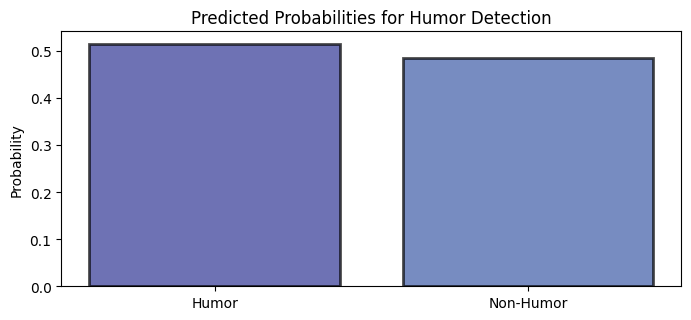

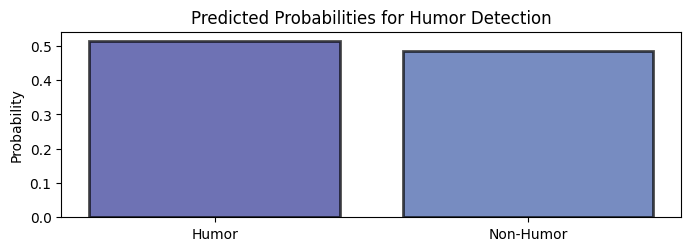

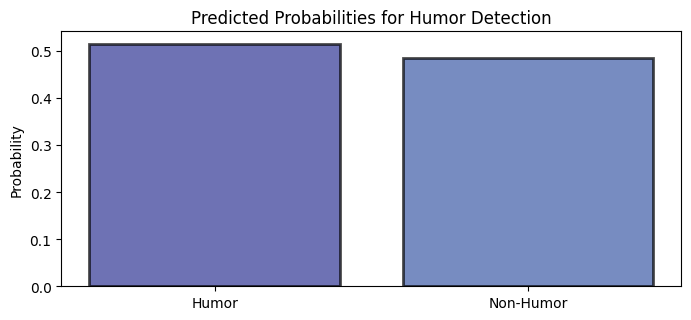

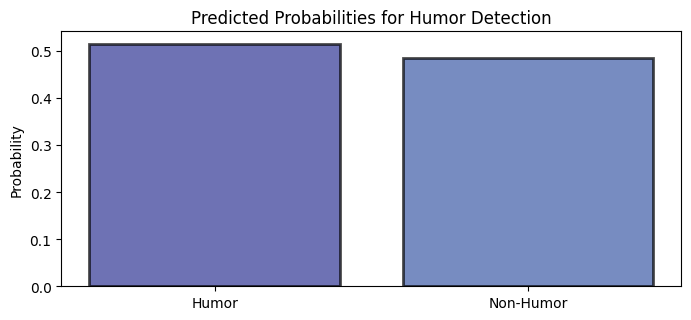

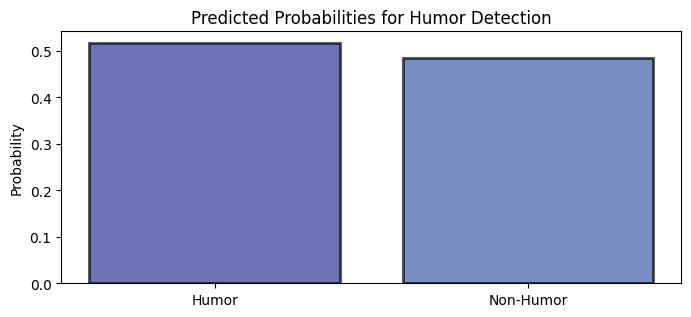

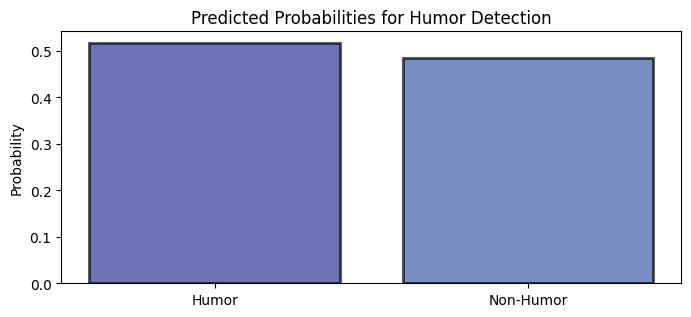

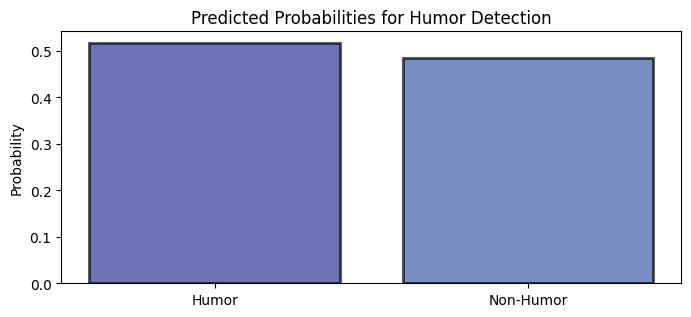

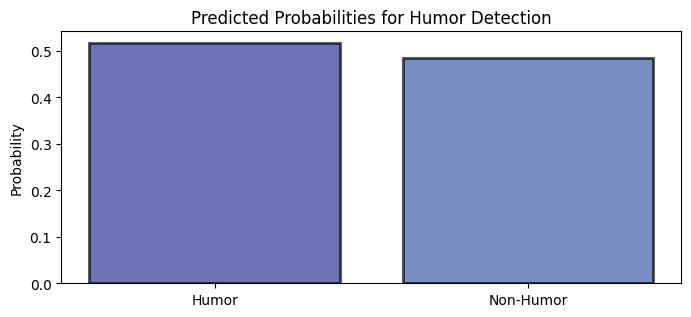

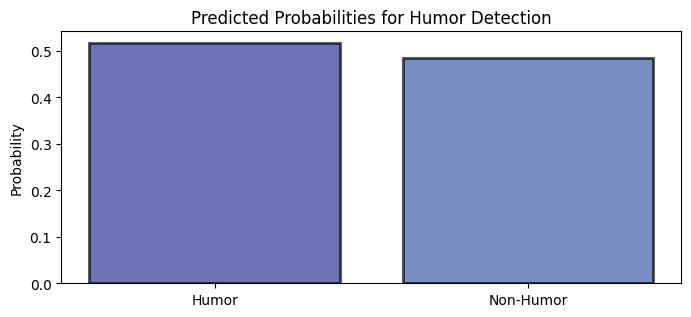

In [12]:
import tkinter as tk
from tkinter import filedialog
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import torch
import tensorflow as tf
import torchaudio
from moviepy.editor import VideoFileClip
from PIL import Image, ImageTk
from tkinter import font
from transformers import VideoMAEImageProcessor, VideoMAEModel, ASTFeatureExtractor, ASTModel, AutoImageProcessor
import av
import pandas as pd
import re
import numpy as np
import pickle
import os
import pandas as pd
import glob

global_predictions = None

torch.cuda.set_device(0)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

# Define the audio processor and model (please adjust these to your actual audio processor and model)
audio_processor = ASTFeatureExtractor()
audio_model = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593").to(device)

# Function to get embeddings from audio files
def get_embeddings_audio(file):
    # Load stereo audio
    stereo_audio, sample_rate = torchaudio.load(file)
    
    # Convert stereo to mono
    mono_audio = stereo_audio.mean(dim=0)
    
    # Resample to 16 kHz
    resample = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    mono_audio_16khz = resample(mono_audio)

    # Load the audio processor
    audio_processor = ASTFeatureExtractor()
    
    # Move the audio processor to the desired device
    #audio_processor = audio_processor.to(device)
    
    inputs = audio_processor(mono_audio_16khz, sampling_rate=16000, return_tensors="pt").to(device)
    inputs = inputs.to(device)
    
    with torch.no_grad():
        outputs = audio_model(**inputs)
    
    last_hidden_states = outputs.last_hidden_state 
    
    features_audio = last_hidden_states.cpu().numpy()
    
    return features_audio

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

# Function to get embeddings from video files
def get_embeddings_video(file, device):
    
    container = av.open(file)
    
    # Sample 16 frames
    indices = sample_frame_indices(clip_len=16, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
    video = read_video_pyav(container, indices)

    # Load image processor and model
    image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
    model = VideoMAEModel.from_pretrained("MCG-NJU/videomae-base")
    model.to(device)

    # Process the video frames
    inputs = image_processor(list(video), return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state

    # Extract features (mean pooling) and move to CPU
    #features = last_hidden_states.mean(dim=1).squeeze().to("cpu").numpy()
    features = last_hidden_states.to("cpu").numpy()
    return features

# Function to preprocess embeddings if necessary
# def preprocess_embeddings(embeddings):
# Add preprocessing steps here if needed
# return embeddings

# Function to make predictions
def make_predictions(audio_embeddings, video_embeddings):
    # Move tensors to the desired device
    audio_embeddings = torch.tensor(audio_embeddings).to(device)
    video_embeddings = torch.tensor(video_embeddings).to(device)

    # Move tensors to CPU before passing to TensorFlow model
    audio_embeddings_cpu = audio_embeddings.cpu()
    video_embeddings_cpu = video_embeddings.cpu()
    
    # Make predictions
    with torch.no_grad():
        predictions = loaded_model((audio_embeddings_cpu, video_embeddings_cpu))
    return predictions


# Function to plot predicted probabilities inside the specified frame
def plot_predictions_tk(root):
    try:
        # Retrieve global predictions
        predictions = global_predictions

        # Calculate color intensity based on probability values
        color_intensity = predictions[0] / np.max(predictions[0])

        # Create a figure and a subplot
        fig, ax = plt.subplots(figsize=(8, 6))
        classes = ['Humor', 'Non-Humor']
        bars = ax.bar(classes, predictions[0], color=plt.cm.RdYlBu(color_intensity))

        # Customize the bar graph styling
        for i, bar in enumerate(bars):
            # Change the edge color of the bars
            bar.set_edgecolor('black')
            # Change the line width of the bars
            bar.set_linewidth(2)
            # Change the opacity of the bars
            bar.set_alpha(0.7)

        ax.set_ylabel('Probability')
        ax.set_title('Predicted Probabilities for Humor Detection')

        

        # Embed the plot in the Tkinter window
        canvas = FigureCanvasTkAgg(fig, master=root)
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

    except Exception as e:
        print("Error plotting predictions:", e)


# Define the display_video function
# Function to display video in the Tkinter window
# Function to display video in the Tkinter window
def display_video(video_path, root):
    try:
        # Destroy any existing video frame and graph frame
        for widget in root.winfo_children():
            if isinstance(widget, tk.Frame) and widget.winfo_name() == "video_frame":
                widget.destroy()
            elif isinstance(widget, tk.Frame) and widget.winfo_name() == "graph_frame":
                widget.destroy()

        # Create a frame for the video player
        video_frame = tk.Frame(root, bg="black", name="video_frame", width=640, height=480)
        video_frame.pack(pady=20)

        # Load the video clip
        video_clip = VideoFileClip(video_path)

        # Define the width and height of the video player
        player_width = 480
        player_height = 360

        # Calculate the aspect ratio of the video
        aspect_ratio = video_clip.size[0] / video_clip.size[1]

        # Calculate the height of the video player based on the width and aspect ratio
        player_height = int(player_width / aspect_ratio)

        # Create a label for the video player
        video_player = tk.Label(video_frame)
        video_player.pack()

        # Function to update video frames
        def update_video_frame(frame_num):
            # Get the current frame
            frame = video_clip.get_frame(frame_num / video_clip.fps)
            frame = Image.fromarray(frame)
        
            # Resize the frame to fit the video player dimensions
            frame = frame.resize((player_width, player_height), Image.Resampling.LANCZOS)
        
            # Convert the frame to a format compatible with PhotoImage
            frame_tk = ImageTk.PhotoImage(frame)
        
            # Update the video player label with the new frame image
            video_player.config(image=frame_tk)
            video_player.image = frame_tk
        
            # Calculate the delay for the next frame update (in milliseconds)
            delay = int(1000 / video_clip.fps)
        
            # Schedule the next frame update
            frame_num += 1
            if frame_num < video_clip.fps * video_clip.duration:
                video_player.after(delay, update_video_frame, frame_num)


        # Start updating video frames
        update_video_frame(0)

        # Create a frame for the graph
        graph_frame = tk.Frame(root, bg="#64b6f7", name="graph_frame", width=640, height=200)
        graph_frame.pack(pady=20)

        # Plot the predicted probabilities inside the graph frame
        plot_predictions_tk(graph_frame)

    except Exception as e:
        print("Error displaying video:", e)



# Function to handle file selection
def select_files():
    
    global global_predictions
    
    # Open file dialog to select video file
    video_path = filedialog.askopenfilename(title="Select Video File")
    if video_path:
        
        # Extract audio from video
        video_clip = VideoFileClip(video_path)
        audio_path = "D:\ML Projects\extracted_audio.wav"
        video_clip.audio.write_audiofile(audio_path)

        # Get audio embeddings
        audio_embeddings = get_embeddings_audio(audio_path)
        # Preprocess audio embeddings if necessary
        # audio_embeddings = preprocess_embeddings(audio_embeddings)

        print("Audio Embedding: ", audio_embeddings)
        print("Audio Embedding Shape:", audio_embeddings.shape)

        # Get video embeddings
        video_embeddings = get_embeddings_video(video_path, device)
        # Preprocess video embeddings if necessary
        # video_embeddings = preprocess_embeddings(video_embeddings)

        print("Video Embedding: ", video_embeddings)
        print("Video Embedding Shape: ", video_embeddings.shape)

        # Make predictions
        global_predictions = make_predictions(audio_embeddings, video_embeddings)
        #print(type(predictions))
        # Plot predicted probabilities inside Tkinter window
        #plot_predictions_tk(predictions)
        
        # Display video in the Tkinter window
        display_video(video_path, root)
        # Run the Tkinter main loop
        
        root.mainloop()

# Set device
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
# Create the main application window
root = tk.Tk()
root.title("😄 Audio-Visual Humor Detection App 😄")
root.geometry("800x900")
root.configure(bg="#aad2f2")


font_path = "/home/orchid/Downloads/comic-sans/COMICSANSBOLD.TTF"

# Create a Font object with the desired font style
custom_font = font.Font(family="FontName", size=14, weight="bold", slant="italic")

# Create a frame for the buttons
button_frame = tk.Frame(root, bg="#aad2f2")
button_frame.pack(pady=20)

# Create a button to select files
select_button = tk.Button(button_frame, text="Select Video File", command=select_files, font=custom_font)
select_button.pack(side=tk.LEFT, padx=10)

predict_button = tk.Button(root, text="Predict", command=plot_predictions_tk, font=custom_font)
predict_button.pack(pady=20)
    
# Run the application
root.mainloop()


In [3]:
pip show torch torchaudio


Name: torch
Version: 2.3.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/orchid/anaconda3/envs/tf_gpu/lib/python3.9/site-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-nccl-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: speechbrain, torchaudio, torchvision
---
Name: torchaudio
Version: 2.3.0
Summary: An audio package for PyTorch
Home-page: https://github.com/pytorch/audio
Author: Soumith Chintala, David Pollack, Sean Naren, Peter Goldsborough, Moto Hira, Caroline Chen, Jeff Hwang, Zhaoheng Ni, Xiaohui Zhang
Author-email: soumith@pytorch.org
License: 
Location: /home/orchid/anaconda3/envs/tf_gpu/lib/pyt

In [4]:
conda activate .


CondaError: Run 'conda init' before 'conda activate'


Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torchaudio==2.2.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 5.7 MB/s eta 0:00:005.8 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 3.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 10.4 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.20.5
    Uninstalling nvidia-nccl-cu12-2.20.5:
      Successfully uninstalled nvidia-nccl-cu12-2.20.5
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0
    Uninstalling torch-2.3.0:
      Successfully uninstalled torch-2.3.0
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.3.0
    Uninstalling torchaudio-2.3.0:
    

In [3]:
pip install av

Note: you may need to restart the kernel to use updated packages.


------------------------------------------------------------------------------------------------------------------------------------

In [6]:
import tkinter as tk
from tkinter import filedialog
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import torch
import torchaudio
from moviepy.editor import VideoFileClip
from PIL import Image, ImageTk
from tkinter import font
from transformers import VideoMAEImageProcessor, VideoMAEModel, ASTFeatureExtractor, ASTModel, AutoImageProcessor
import av
import pandas as pd

global_predictions = None

# Set device to CPU
device = torch.device("cpu")

# Define the audio processor and model
audio_processor = ASTFeatureExtractor()
audio_model = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593").to(device)

# Function to get embeddings from audio files
def get_embeddings_audio(file):
    # Load stereo audio
    stereo_audio, sample_rate = torchaudio.load(file)
    
    # Convert stereo to mono
    mono_audio = stereo_audio.mean(dim=0)
    
    # Resample to 16 kHz
    resample = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
    mono_audio_16khz = resample(mono_audio)

    inputs = audio_processor(mono_audio_16khz, sampling_rate=16000, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = audio_model(**inputs)
    
    last_hidden_states = outputs.last_hidden_state 
    features_audio = last_hidden_states.cpu().numpy()
    
    return features_audio

def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

# Function to get embeddings from video files
def get_embeddings_video(file, device):
    container = av.open(file)
    
    # Sample 16 frames
    indices = sample_frame_indices(clip_len=16, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
    video = read_video_pyav(container, indices)

    # Load image processor and model
    image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
    model = VideoMAEModel.from_pretrained("MCG-NJU/videomae-base")
    model.to(device)

    # Process the video frames
    inputs = image_processor(list(video), return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state

    # Extract features and move to CPU
    features = last_hidden_states.to("cpu").numpy()
    return features

# Function to preprocess embeddings if necessary
# def preprocess_embeddings(embeddings):
# Add preprocessing steps here if needed
# return embeddings

# Function to make predictions
def make_predictions(audio_embeddings, video_embeddings):
    # Move tensors to the desired device
    audio_embeddings = torch.tensor(audio_embeddings).to(device)
    video_embeddings = torch.tensor(video_embeddings).to(device)

    # Move tensors to CPU before passing to TensorFlow model
    audio_embeddings_cpu = audio_embeddings.cpu()
    video_embeddings_cpu = video_embeddings.cpu()
    
    # Make predictions
    with torch.no_grad():
        predictions = loaded_model((audio_embeddings_cpu, video_embeddings_cpu))
    return predictions

# Function to plot predicted probabilities inside the specified frame
def plot_predictions_tk(root):
    try:
        # Retrieve global predictions
        predictions = global_predictions

        # Calculate color intensity based on probability values
        color_intensity = predictions[0] / np.max(predictions[0])

        # Create a figure and a subplot
        fig, ax = plt.subplots(figsize=(8, 6))
        classes = ['Humor', 'Non-Humor']
        bars = ax.bar(classes, predictions[0], color=plt.cm.RdYlBu(color_intensity))

        # Customize the bar graph styling
        for i, bar in enumerate(bars):
            bar.set_edgecolor('black')
            bar.set_linewidth(2)
            bar.set_alpha(0.7)

        ax.set_ylabel('Probability')
        ax.set_title('Predicted Probabilities for Humor Detection')

        # Embed the plot in the Tkinter window
        canvas = FigureCanvasTkAgg(fig, master=root)
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

    except Exception as e:
        print("Error plotting predictions:", e)

# Define the display_video function
def display_video(video_path, root):
    try:
        # Destroy any existing video frame and graph frame
        for widget in root.winfo_children():
            if isinstance(widget, tk.Frame) and widget.winfo_name() == "video_frame":
                widget.destroy()
            elif isinstance(widget, tk.Frame) and widget.winfo_name() == "graph_frame":
                widget.destroy()

        # Create a frame for the video player
        video_frame = tk.Frame(root, bg="black", name="video_frame", width=640, height=480)
        video_frame.pack(pady=20)

        # Load the video clip
        video_clip = VideoFileClip(video_path)

        # Define the width and height of the video player
        player_width = 480
        player_height = 360

        # Calculate the aspect ratio of the video
        aspect_ratio = video_clip.size[0] / video_clip.size[1]

        # Calculate the height of the video player based on the width and aspect ratio
        player_height = int(player_width / aspect_ratio)

        # Create a label for the video player
        video_player = tk.Label(video_frame)
        video_player.pack()

        # Function to update video frames
        def update_video_frame(frame_num):
            frame = video_clip.get_frame(frame_num)
            frame = Image.fromarray(frame)

            # Resize the frame to fit the video player dimensions
            frame = frame.resize((player_width, player_height), Image.Resampling.LANCZOS)

            # Convert the frame to a format compatible with PhotoImage
            frame_tk = ImageTk.PhotoImage(frame)

            # Update the video player label with the new frame image
            video_player.config(image=frame_tk)
            video_player.image = frame_tk

            frame_num += 1
            if frame_num < video_clip.fps * video_clip.duration:
                video_player.after(int(1000 / video_clip.fps), update_video_frame, frame_num)

        # Start updating video frames
        update_video_frame(0)

        # Create a frame for the graph
        graph_frame = tk.Frame(root, bg="#64b6f7", name="graph_frame", width=640, height=200)
        graph_frame.pack(pady=20)

        # Plot the predicted probabilities inside the graph frame
        plot_predictions_tk(graph_frame)

    except Exception as e:
        print("Error displaying video:", e)

# Function to handle file selection
def select_files():
    global global_predictions
    
    # Open file dialog to select video file
    video_path = filedialog.askopenfilename(title="Select Video File")
    if video_path:
        
        # Extract audio from video
        video_clip = VideoFileClip(video_path)
        audio_path = "D:\ML Projects\extracted_audio.wav"
        video_clip.audio.write_audiofile(audio_path)

        # Get audio embeddings
        audio_embeddings = get_embeddings_audio(audio_path)
        print("Audio Embedding: ", audio_embeddings)
        print("Audio Embedding Shape:", audio_embeddings.shape)

        # Get video embeddings
        video_embeddings = get_embeddings_video(video_path, device)
        print("Video Embedding: ", video_embeddings)
        print("Video Embedding Shape: ", video_embeddings.shape)

        # Make predictions
        global_predictions = make_predictions(audio_embeddings, video_embeddings)
        
        # Display video in the Tkinter window
        display_video(video_path, root)
        # Run the Tkinter main loop
        root.mainloop()

# Create the main application window
root = tk.Tk()
root.title("😄 Audio-Visual Humor Detection App 😄")
root.geometry("800x900")
root.configure(bg="#aad2f2")

# Set custom font
custom_font = font.Font(family="FontName", size=14, weight="bold", slant="italic")

# Create a frame for the buttons
button_frame = tk.Frame(root, bg="#aad2f2")
button_frame.pack(pady=20)

# Create a button to select files
select_button = tk.Button(button_frame, text="Select Video File", command=select_files, font=custom_font)
select_button.pack(side=tk.LEFT, padx=10)

# Create a button to plot predictions
predict_button = tk.Button(root, text="Predict", command=plot_predictions_tk, font=custom_font)
predict_button.pack(pady=20)

# Run the application
root.mainloop()


MoviePy - Writing audio in D:\ML Projects\extracted_audio.wav


MoviePy - Done.
Audio Embedding:  [[[-0.80248487  1.1352621  -2.147833   ... -0.29702353 -1.6939312
   -0.9103385 ]
  [-0.17642474  1.3793617  -2.534024   ... -0.13638361 -1.9629129
   -0.24068466]
  [ 1.2526329   0.39374483  1.5560343  ... -0.2307866   1.0371034
    0.572249  ]
  ...
  [ 1.2963486  -0.46350488 -0.9144776  ... -0.48893672 -0.12671973
    0.6623136 ]
  [ 1.177041   -0.72105926 -0.5434967  ... -1.3205117   0.86278594
    0.32437947]
  [ 0.38499838 -1.1387063   1.306373   ... -1.1604868  -0.5467357
    0.8048364 ]]]
Audio Embedding Shape: (1, 1214, 768)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Video Embedding:  [[[ 0.04243786 -0.19533424  0.11414342 ...  0.57641256  0.3108435
   -0.09121644]
  [-0.37865394 -0.21383259 -0.13900143 ...  0.31971702  0.21590193
   -0.11469041]
  [-0.97484505 -0.20145309 -0.04532044 ...  0.21431695  0.01425151
   -0.1550493 ]
  ...
  [ 0.18388176 -0.2466343  -0.09750644 ... -0.20355046  0.0487081
   -0.09649885]
  [ 0.9518313   0.05912675  0.02098876 ...  0.11576055  0.1647409
   -0.01283726]
  [ 0.95388824 -0.08444376  0.20056887 ... -0.19318655 -0.14830513
   -0.31138426]]]
Video Embedding Shape:  (1, 1568, 768)


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\shubh\miniconda3\envs\tf\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\shubh\AppData\Local\Temp\ipykernel_7272\1960496907.py", line 246, in select_files
    global_predictions = make_predictions(audio_embeddings, video_embeddings)
  File "C:\Users\shubh\AppData\Local\Temp\ipykernel_7272\1960496907.py", line 125, in make_predictions
    predictions = loaded_model((audio_embeddings_cpu, video_embeddings_cpu))
NameError: name 'loaded_model' is not defined
